In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import warnings
warnings.filterwarnings('ignore')
import time

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [5]:
from sklearn.tree import plot_tree

In [7]:
#Reading the data and viewing the first five rows
df = pd.read_csv("Car details v3.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [8]:
df.tail()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0
8127,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


# Data Preprocessing

In [9]:
#Checking the data types of the columns and the number of rows in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


## Handling Missing Values

In [10]:
#Viewing the number of null values in each column
df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [11]:
#Let's check the number of rows where four or more columns have null values
df[df.isnull().sum(axis=1) >= 4].shape

(221, 13)

Since four columns have missing values in the same columns, these rows are not useful data points for model training. Let's drop these rows.

In [12]:
#Dropping the rows that have null values in four or more columns
print("Dataframe shape before dropping rows: ", df.shape)
df = df[~ (df.isnull().sum(axis=1) >= 4)]
print("Dataframe shape after dropping rows: ", df.shape)

Dataframe shape before dropping rows:  (8128, 13)
Dataframe shape after dropping rows:  (7907, 13)


We can see that 221 rows were dropped. Let's revisit the number of null values in each column.

In [13]:
#Checking the number of missing values again
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           1
seats            0
dtype: int64

Let's check the row that has a null value in the torque column.

In [14]:
#Checking the row with the missing value
df[df['torque'].isnull()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0


Since cars have standard torque values, we can find the torque generated by a Maruti Omni CNG and impute that value in this row.

In [15]:
#Checking for other data points on 'Maruti Omni CNG'
df[df['name']=='Maruti Omni CNG']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0


There is only one entry in our dataset for a CNG Omni. Let's look at the torque and max power of Omnis that were manufactured at around the same time.

In [16]:
#Checking for other Omnis that were manufactured before 2010
df[(df['name'].str.contains('Omni')) & (df['year']<2010)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
818,Maruti Omni 8 Seater BSII,2009,101000,90000,Petrol,Individual,Manual,Fourth & Above Owner,19.7 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,8.0
2327,Maruti Omni 5 Str STD,1998,80000,70000,Petrol,Individual,Manual,First Owner,14.0 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,5.0
2465,Maruti Omni 8 Seater BSIV,2008,114999,58632,Petrol,Dealer,Manual,Second Owner,14.0 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,5.0
3515,Maruti Omni 8 Seater BSII,2008,100000,120000,Petrol,Individual,Manual,Second Owner,19.7 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,8.0
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0
5670,Maruti Omni MPI STD BSIII 8-STR W/ IMMOBILISER,2008,110000,48676,Petrol,Individual,Manual,First Owner,19.7 kmpl,796 CC,35 bhp,"6.1@ 3,000(kgm@ rpm)",8.0
6007,Maruti Omni LPG CARGO BSIII W IMMOBILISER,2007,54000,144000,LPG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,32.8 bhp,57Nm@ 2500rpm,5.0
7594,Maruti Omni MPI STD BSIII 8-STR W/ IMMOBILISER,2008,110000,48676,Petrol,Individual,Manual,First Owner,19.7 kmpl,796 CC,35 bhp,"6.1@ 3,000(kgm@ rpm)",8.0
7729,Maruti Omni 8 Seater BSII,2008,160000,70000,Petrol,Individual,Manual,Fourth & Above Owner,19.7 kmpl,796 CC,35 bhp,6.1kgm@ 3000rpm,8.0


From the results, it appears that '6.1kgm@3000rpm' is the torque rating of Omnis produced at this time, and their max power is 35 bhp.

In [17]:
#Imputing these values for the Maruti Omni CNG
df['torque'][df['name']=='Maruti Omni CNG'] = '6.1kgm@3000rpm'
df['max_power'][df['name']=='Maruti Omni CNG'] = '35 bhp'
df[df['name']=='Maruti Omni CNG']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,35 bhp,6.1kgm@3000rpm,8.0


In [18]:
#Checking the number of missing values again and the data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           7907 non-null   object 
 1   year           7907 non-null   int64  
 2   selling_price  7907 non-null   int64  
 3   km_driven      7907 non-null   int64  
 4   fuel           7907 non-null   object 
 5   seller_type    7907 non-null   object 
 6   transmission   7907 non-null   object 
 7   owner          7907 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7907 non-null   object 
 11  torque         7907 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 864.8+ KB


## Checking the Levels in Categorical Variables

Since there are many string-type columns that are to be treated as categorical data, let's check the categories in each of these columns.

In [19]:
#Checking the 'fuel' column
df['fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

The categories in this column are fine.

In [20]:
#Checking the 'seller_type' column
df['seller_type'].unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

In [21]:
#Checking the counts for each of these categories
df['seller_type'].value_counts()

Individual          6564
Dealer              1107
Trustmark Dealer     236
Name: seller_type, dtype: int64

'Trustmark Dealer' and 'Dealer' appear to be different categories.

In [22]:
#Checking the 'transmission' column
df['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [23]:
#Checking the 'owner' column
df['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [24]:
#Checking the 'mileage' column
df['mileage'].unique()

array(['23.4 kmpl', '21.14 kmpl', '17.7 kmpl', '23.0 kmpl', '16.1 kmpl',
       '20.14 kmpl', '17.3 km/kg', '23.59 kmpl', '20.0 kmpl',
       '19.01 kmpl', '17.3 kmpl', '19.3 kmpl', '18.9 kmpl', '18.15 kmpl',
       '24.52 kmpl', '19.7 kmpl', '22.54 kmpl', '21.0 kmpl', '25.5 kmpl',
       '26.59 kmpl', '21.5 kmpl', '20.3 kmpl', '21.4 kmpl', '24.7 kmpl',
       '18.2 kmpl', '16.8 kmpl', '24.3 kmpl', '14.0 kmpl', '18.6 kmpl',
       '33.44 km/kg', '23.95 kmpl', '17.0 kmpl', '20.63 kmpl',
       '13.93 kmpl', '16.0 kmpl', '17.8 kmpl', '18.5 kmpl', '12.55 kmpl',
       '12.99 kmpl', '14.8 kmpl', '13.5 kmpl', '26.0 kmpl', '20.65 kmpl',
       '27.3 kmpl', '11.36 kmpl', '17.68 kmpl', '14.28 kmpl',
       '18.53 kmpl', '14.84 kmpl', '21.12 kmpl', '20.36 kmpl',
       '21.27 kmpl', '18.16 kmpl', '22.0 kmpl', '25.1 kmpl', '20.51 kmpl',
       '21.66 kmpl', '25.2 kmpl', '22.9 kmpl', '16.02 kmpl', '20.54 kmpl',
       '22.77 kmpl', '15.71 kmpl', '23.1 kmpl', '19.02 kmpl',
       '19.81 kmpl', '26

It appears that there are two units: 'kmpl' and 'km/kg'. Let's check the different categories of units.

In [25]:
#Getting the unique values in the 'mileage' column and assigning them to a list
mileage_list = df['mileage'].unique().tolist()

#Extracting the alphabets (and forward slash) from these unique values
mileage_list = ["".join(re.split("[^a-zA-Z//]*", m)) for m in mileage_list]

#Checking the unique units in the mileage column
pd.Series(mileage_list).unique()

array(['kmpl', 'km/kg'], dtype=object)

To convert km/kg to kmpl, we need to know the fuel type. Let's check for which fuels the mileage values are given in km/kg.

In [26]:
#Checking the fuel column where mileage is in km/kg
df['fuel'][df['mileage'].str.contains('km/kg')].unique()

array(['LPG', 'CNG'], dtype=object)

In India, 1 kg of LPG is equivalent to 1.8 litres. 1 kg of CNG is equivalent to 1.4 litres of the fuel. Let's use this to convert kg/km to kmpl.

In [27]:
#Writing a function that converts kg/km to kmpl and convert the column to a float type

def mileage_converter(row):
    if row['fuel'] == 'LPG':
        if row['mileage'].endswith('km/kg'):
            mileage = "".join([char for char in row['mileage'] if (char.isnumeric() or char.isspace() or char=='.')])
            mileage = round(float(mileage.strip())/1.8, 3)
            row['mileage'] = mileage
            
    elif row['fuel'] =='CNG':
        if row['mileage'].endswith('km/kg'):
            mileage = "".join([char for char in row['mileage'] if (char.isnumeric() or char.isspace() or char=='.')])
            mileage = round(float(mileage.strip())/1.4, 3)
            row['mileage'] = mileage
    
    else:
        mileage = "".join([char for char in row['mileage'] if (char.isnumeric() or char.isspace() or char=='.')])
        mileage = float(mileage.strip())
    
    #Checking the original mileage value when the converted value is zero
    if mileage==0.0:
        print("Converted value: ", mileage)
        print("Original value: ", row['mileage'])
    
    #Inserting the value into the row
    row['mileage'] = mileage
    
    return row
    

In [28]:
#Applying the function to the dataframe
df = df.apply(mileage_converter, axis=1)

Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl
Converted value:  0.0
Original value:  0.0 kmpl


In [29]:
#Checking the data type of the mileage column
df['mileage'].dtype

dtype('float64')

In [30]:
#Checking the rows that have CNG or LPG as the fuel type
df[(df['fuel']=='CNG') | (df['fuel']=='LPG')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,9.611,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0
35,Maruti Alto 800 CNG LXI Optional,2019,330000,10000,CNG,Individual,Manual,Second Owner,23.886,796 CC,40.3 bhp,60Nm@ 3500rpm,4.0
90,Maruti Wagon R LXI LPG BSIV,2010,225000,44000,LPG,Dealer,Manual,First Owner,14.556,998 CC,58.2 bhp,77Nm@ 3500rpm,5.0
203,Maruti Wagon R LXI CNG,2016,360000,50000,CNG,Individual,Manual,First Owner,19.000,998 CC,58.16 bhp,77Nm@ 3500rpm,5.0
402,Maruti Eeco CNG 5 Seater AC,2020,409999,35000,CNG,Individual,Manual,First Owner,14.914,1196 CC,61.7 bhp,85Nm@ 3000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7308,Maruti Alto Green LXi (CNG),2010,155000,70000,CNG,Individual,Manual,Second Owner,19.164,796 CC,38.4 bhp,62Nm@ 3000rpm,5.0
7543,Maruti Alto 800 CNG LXI Optional,2019,330000,10000,CNG,Individual,Manual,Second Owner,23.886,796 CC,40.3 bhp,60Nm@ 3500rpm,4.0
7642,Chevrolet Spark 1.0 LT LPG,2012,300000,70000,LPG,Individual,Manual,First Owner,7.333,995 CC,60.2 bhp,90.3Nm@ 4200rpm,5.0
7733,Maruti Eeco CNG 5 Seater AC BSIV,2015,380000,20000,CNG,Individual,Manual,First Owner,15.671,1196 CC,61.7 bhp,85Nm@ 3000rpm,5.0


The mileage for these cars appears to be have been converted successfully.

Let's indicate the units in the mileage column name.

In [31]:
df.rename(columns = {'mileage': 'mileage_in_kmpl'}, inplace=True)

In [32]:
#Performing a sanity check
df['mileage_in_kmpl'].describe()

count    7907.000000
mean       19.335956
std         4.044932
min         0.000000
25%        16.780000
50%        19.300000
75%        22.320000
max        42.000000
Name: mileage_in_kmpl, dtype: float64

A minimum mileage of zero seems to be incorrect. As we've seen, this appears to be an issue with the original mileage value in the dataframe. Let's deal with this during outlier detection.

Let's resume checking the other string-type columns.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             7907 non-null   object 
 1   year             7907 non-null   int64  
 2   selling_price    7907 non-null   int64  
 3   km_driven        7907 non-null   int64  
 4   fuel             7907 non-null   object 
 5   seller_type      7907 non-null   object 
 6   transmission     7907 non-null   object 
 7   owner            7907 non-null   object 
 8   mileage_in_kmpl  7907 non-null   float64
 9   engine           7907 non-null   object 
 10  max_power        7907 non-null   object 
 11  torque           7907 non-null   object 
 12  seats            7907 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 864.8+ KB


In [34]:
#Checking the engine column
df['engine'].unique()

array(['1248 CC', '1498 CC', '1497 CC', '1396 CC', '1298 CC', '1197 CC',
       '1061 CC', '796 CC', '1364 CC', '1399 CC', '1461 CC', '993 CC',
       '1198 CC', '1199 CC', '998 CC', '1591 CC', '2179 CC', '1368 CC',
       '2982 CC', '2494 CC', '2143 CC', '2477 CC', '1462 CC', '2755 CC',
       '1968 CC', '1798 CC', '1196 CC', '1373 CC', '1598 CC', '1998 CC',
       '1086 CC', '1194 CC', '1172 CC', '1405 CC', '1582 CC', '999 CC',
       '2487 CC', '1999 CC', '3604 CC', '2987 CC', '1995 CC', '1451 CC',
       '1969 CC', '2967 CC', '2497 CC', '1797 CC', '1991 CC', '2362 CC',
       '1493 CC', '1599 CC', '1341 CC', '1794 CC', '799 CC', '1193 CC',
       '2696 CC', '1495 CC', '1186 CC', '1047 CC', '2498 CC', '2956 CC',
       '2523 CC', '1120 CC', '624 CC', '1496 CC', '1984 CC', '2354 CC',
       '814 CC', '793 CC', '1799 CC', '936 CC', '1956 CC', '1997 CC',
       '1499 CC', '1948 CC', '2997 CC', '2489 CC', '2499 CC', '2609 CC',
       '2953 CC', '1150 CC', '1994 CC', '1388 CC', '1527 CC'

Let's remove the 'CC' at the end and convert this to a numeric-type column.

In [35]:
#Removing the 'cc'
df['engine'] = [re.sub('C', '', ele) for ele in df['engine']]

#Removing leading and trailing spaces 
df['engine'] = df['engine'].str.strip()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             7907 non-null   object 
 1   year             7907 non-null   int64  
 2   selling_price    7907 non-null   int64  
 3   km_driven        7907 non-null   int64  
 4   fuel             7907 non-null   object 
 5   seller_type      7907 non-null   object 
 6   transmission     7907 non-null   object 
 7   owner            7907 non-null   object 
 8   mileage_in_kmpl  7907 non-null   float64
 9   engine           7907 non-null   object 
 10  max_power        7907 non-null   object 
 11  torque           7907 non-null   object 
 12  seats            7907 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 864.8+ KB


In [37]:
#Converting the column to a numeric type
df['engine'] = pd.to_numeric(df['engine'], downcast='integer')

#Checking the datatype of the column
df['engine'].dtype

dtype('int16')

In [38]:
#Renaming the column to include the units in the column name
df.rename(columns = {'engine': 'engine_in_cc'}, inplace=True)

In [39]:
#Performing a sanity check
df['engine_in_cc'].describe()

count    7907.000000
mean     1458.625016
std       503.916303
min       624.000000
25%      1197.000000
50%      1248.000000
75%      1582.000000
max      3604.000000
Name: engine_in_cc, dtype: float64

The maximum engine capacity is 3.6L, which is a reasonable value.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             7907 non-null   object 
 1   year             7907 non-null   int64  
 2   selling_price    7907 non-null   int64  
 3   km_driven        7907 non-null   int64  
 4   fuel             7907 non-null   object 
 5   seller_type      7907 non-null   object 
 6   transmission     7907 non-null   object 
 7   owner            7907 non-null   object 
 8   mileage_in_kmpl  7907 non-null   float64
 9   engine_in_cc     7907 non-null   int16  
 10  max_power        7907 non-null   object 
 11  torque           7907 non-null   object 
 12  seats            7907 non-null   float64
dtypes: float64(2), int16(1), int64(3), object(7)
memory usage: 818.5+ KB


In [41]:
#Checking the max_power column
df['max_power'].unique()

array(['74 bhp', '103.52 bhp', '78 bhp', '90 bhp', '88.2 bhp',
       '81.86 bhp', '57.5 bhp', '37 bhp', '67.1 bhp', '68.1 bhp',
       '108.45 bhp', '60 bhp', '73.9 bhp', '67 bhp', '82 bhp', '88.5 bhp',
       '46.3 bhp', '88.73 bhp', '64.1 bhp', '98.6 bhp', '88.8 bhp',
       '83.81 bhp', '83.1 bhp', '47.3 bhp', '73.8 bhp', '34.2 bhp',
       '35 bhp', '81.83 bhp', '40.3 bhp', '121.3 bhp', '138.03 bhp',
       '160.77 bhp', '117.3 bhp', '116.3 bhp', '83.14 bhp', '67.05 bhp',
       '168.5 bhp', '100 bhp', '120.7 bhp', '98.63 bhp', '175.56 bhp',
       '103.25 bhp', '171.5 bhp', '100.6 bhp', '174.33 bhp', '187.74 bhp',
       '170 bhp', '78.9 bhp', '88.76 bhp', '86.8 bhp', '108.495 bhp',
       '108.62 bhp', '93.7 bhp', '103.6 bhp', '98.59 bhp', '189 bhp',
       '67.04 bhp', '68.05 bhp', '58.2 bhp', '82.85 bhp', '81.80 bhp',
       '73 bhp', '120 bhp', '94.68 bhp', '160 bhp', '65 bhp', '155 bhp',
       '69.01 bhp', '126.32 bhp', '138.1 bhp', '83.8 bhp', '126.2 bhp',
       '98.96 bh

Let's remove the 'bhp' at the end and convert this to a float-type column.

In [42]:
#Removing the 'bhp'
df['max_power'] = [re.sub('[bhp]', '', ele) for ele in df['max_power']]

#Removing leading and trailing spaces 
df['max_power'] = df['max_power'].str.strip()

In [43]:
#Converting the column to a numeric type
df['max_power'] = pd.to_numeric(df['max_power'], downcast='float')

#Checking the datatype of the column
df['max_power'].dtype

dtype('float32')

In [44]:
#Renaming the column to include the units in the column name
df.rename(columns = {'max_power': 'max_power_in_bhp'}, inplace=True)

In [45]:
#Performing a sanity check
df['max_power_in_bhp'].describe()

count    7907.000000
mean       91.581177
std        35.750584
min        32.799999
25%        68.050003
50%        82.000000
75%       102.000000
max       400.000000
Name: max_power_in_bhp, dtype: float64

The highest max_power value is 400 bhp, which seems reasonable.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              7907 non-null   object 
 1   year              7907 non-null   int64  
 2   selling_price     7907 non-null   int64  
 3   km_driven         7907 non-null   int64  
 4   fuel              7907 non-null   object 
 5   seller_type       7907 non-null   object 
 6   transmission      7907 non-null   object 
 7   owner             7907 non-null   object 
 8   mileage_in_kmpl   7907 non-null   float64
 9   engine_in_cc      7907 non-null   int16  
 10  max_power_in_bhp  7907 non-null   float32
 11  torque            7907 non-null   object 
 12  seats             7907 non-null   float64
dtypes: float32(1), float64(2), int16(1), int64(3), object(6)
memory usage: 787.6+ KB


In [47]:
#Checking the torque column
df['torque'].unique()

array(['190Nm@ 2000rpm', '250Nm@ 1500-2500rpm', '12.7@ 2,700(kgm@ rpm)',
       '22.4 kgm at 1750-2750rpm', '11.5@ 4,500(kgm@ rpm)',
       '113.75nm@ 4000rpm', '7.8@ 4,500(kgm@ rpm)', '59Nm@ 2500rpm',
       '170Nm@ 1800-2400rpm', '160Nm@ 2000rpm', '248Nm@ 2250rpm',
       '78Nm@ 4500rpm', '84Nm@ 3500rpm', '115Nm@ 3500-3600rpm',
       '200Nm@ 1750rpm', '62Nm@ 3000rpm', '219.7Nm@ 1500-2750rpm',
       '114Nm@ 3500rpm', '115Nm@ 4000rpm', '69Nm@ 3500rpm',
       '172.5Nm@ 1750rpm', '6.1kgm@ 3000rpm', '114.7Nm@ 4000rpm',
       '60Nm@ 3500rpm', '90Nm@ 3500rpm', '151Nm@ 4850rpm',
       '104Nm@ 4000rpm', '320Nm@ 1700-2700rpm', '250Nm@ 1750-2500rpm',
       '145Nm@ 4600rpm', '146Nm@ 4800rpm', '343Nm@ 1400-3400rpm',
       '200Nm@ 1400-3400rpm', '200Nm@ 1250-4000rpm',
       '400Nm@ 2000-2500rpm', '138Nm@ 4400rpm', '360Nm@ 1200-3400rpm',
       '200Nm@ 1200-3600rpm', '380Nm@ 1750-2500rpm', '173Nm@ 4000rpm',
       '400Nm@ 1750-3000rpm', '400Nm@ 1400-2800rpm',
       '200Nm@ 1750-3000rpm', '

In [48]:
df['torque'].value_counts()

190Nm@ 2000rpm           530
200Nm@ 1750rpm           445
90Nm@ 3500rpm            405
113Nm@ 4200rpm           223
114Nm@ 4000rpm           171
                        ... 
17.5@ 4,300(kgm@ rpm)      1
13.9 kgm at 4200 rpm       1
128Nm@ 3100rpm             1
240Nm@ 1850rpm             1
436.4Nm@ 1800-2500rpm      1
Name: torque, Length: 442, dtype: int64

In [49]:
#Defining a function to get only the torque value in newton-metres

def torque_cleaner(row):
    
    #Initializing a list where the numeric characters will be added
    t_value = []
    
    for char in str(row['torque']).strip():
        
        #Adding only the characters that are numbers, spaces, or periods
        if char.isnumeric() or (char=='.') or char.isspace():
            t_value.append(char)
        
        #Ending the loop when a different type of character is encountered
        else:
            break
    
    #Converting the list into a string
    t_value = "".join(t_value)
    
    #Removing leading and trailing whitespaces
    t_value = t_value.strip()
    
    #Converting the variable into a floating-type variable
    t_value = float(t_value)                     
    
    #Converting kgm to Nm
    if ('kgm' in row['torque']) and ('Nm' not in row['torque']):
        t_value = t_value*9.8
    
    #Inserting the converted value into the row
    row['torque'] = t_value
    
    return row
        

In [50]:
#Applying the function
df = df.apply(torque_cleaner, axis=1)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.000000,190.00,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.519997,250.00,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.000000,124.46,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.000000,219.52,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.199997,112.70,5.0


In [51]:
#Performing a sanity check
df['torque'].describe()

count    7907.000000
mean      180.261194
std       109.396519
min        14.900000
25%       111.720000
50%       170.000000
75%       209.000000
max      1862.000000
Name: torque, dtype: float64

A torque of 1862 Nm is extremely high for a road car. Noting that this needs to be corrected during the outlier detection phase.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              7907 non-null   object 
 1   year              7907 non-null   int64  
 2   selling_price     7907 non-null   int64  
 3   km_driven         7907 non-null   int64  
 4   fuel              7907 non-null   object 
 5   seller_type       7907 non-null   object 
 6   transmission      7907 non-null   object 
 7   owner             7907 non-null   object 
 8   mileage_in_kmpl   7907 non-null   float64
 9   engine_in_cc      7907 non-null   int64  
 10  max_power_in_bhp  7907 non-null   float64
 11  torque            7907 non-null   float64
 12  seats             7907 non-null   float64
dtypes: float64(4), int64(4), object(5)
memory usage: 864.8+ KB


In [53]:
#Converting the 'seats' column to an integer type
df['seats'] = df['seats'].astype('int')

In [54]:
df['seats'].dtype

dtype('int32')

In [55]:
#Performing a sanity check
df['seats'].value_counts()

5     6254
7     1120
8      236
4      133
9       80
6       62
10      19
2        2
14       1
Name: seats, dtype: int64

This variable seems to be in order.

# Data Exploration and Visualization

In [56]:
#Calculating the correlation values of all the columns
corr_values = df.corr()

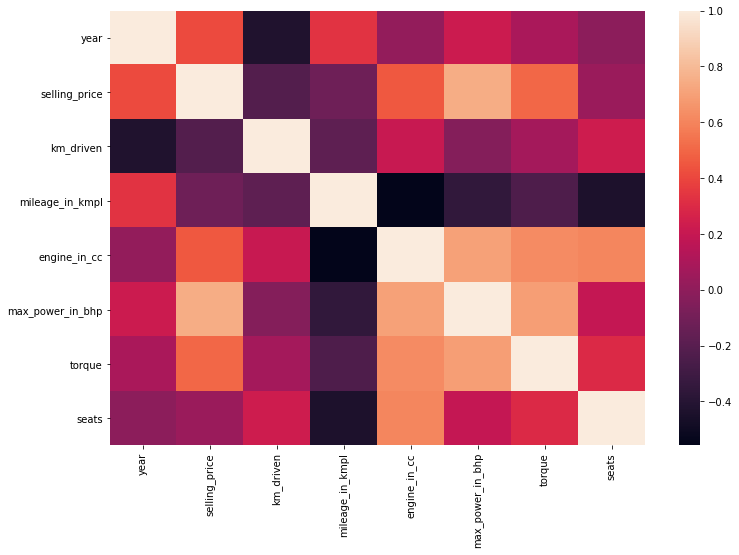

In [57]:
#Plotting a heatmap of the correlation values
plt.figure(figsize=(12,8))
sns.heatmap(corr_values)
plt.show()

As we can see from the heatmap, the selling price is strongly correlated with the max power, followed by the engine capacity. It is also negatively correlated with the kilometres driven and the car's age (year).

Let's plot these variables against the selling price.

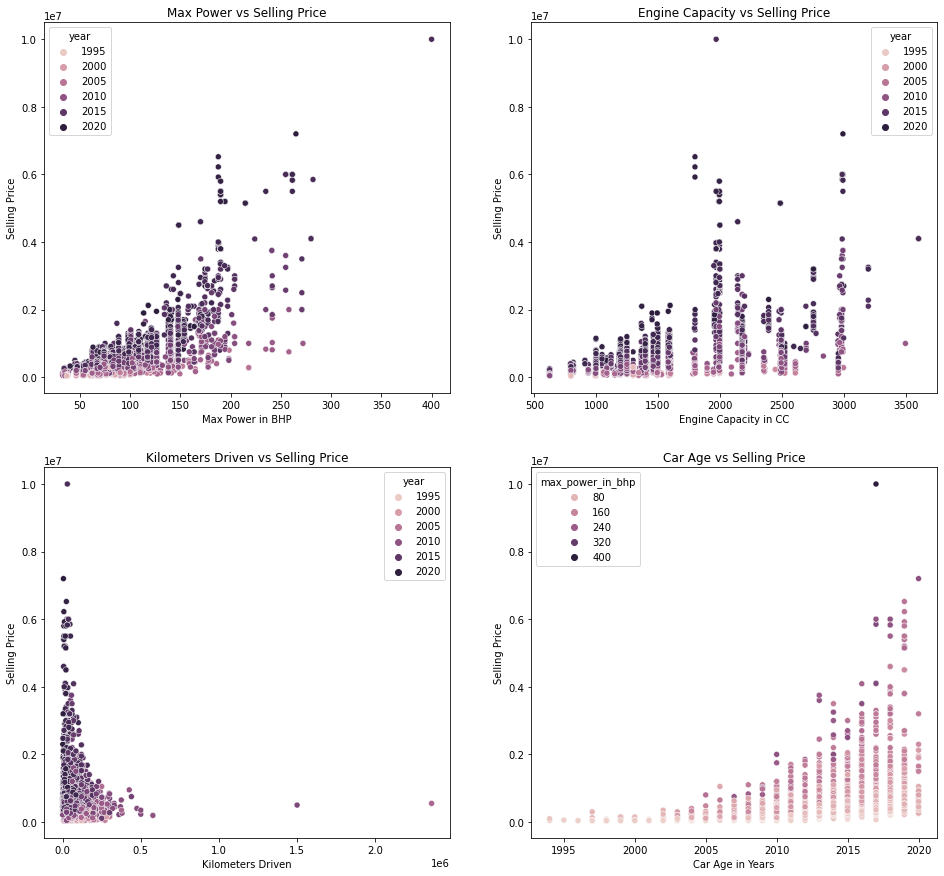

In [58]:
#Defining plotting region
fig, axes = plt.subplots(2, 2, figsize=(16, 15)) #(2 rows, 2 columns)

#Plotting max power against selling price, with year as the hue
sns.scatterplot(x="max_power_in_bhp", y="selling_price", hue="year", data=df, ax=axes[0, 0])
axes[0, 0].set_xlabel("Max Power in BHP")
axes[0, 0].set_ylabel("Selling Price")
axes[0, 0].set_title("Max Power vs Selling Price")

#Plotting engine capacity against engine capacity, with year as the hue
sns.scatterplot(x="engine_in_cc", y="selling_price", hue="year", data=df, ax=axes[0, 1])
axes[0, 1].set_xlabel("Engine Capacity in CC")
axes[0, 1].set_ylabel("Selling Price")
axes[0, 1].set_title("Engine Capacity vs Selling Price")

#Plotting kilometers driven against selling price, with year as the hue
sns.scatterplot(x="km_driven", y="selling_price", hue="year", data=df, ax=axes[1, 0])
axes[1, 0].set_xlabel("Kilometers Driven")
axes[1, 0].set_ylabel("Selling Price")
axes[1, 0].set_title("Kilometers Driven vs Selling Price")

#Plotting year against selling price, with max power as the hue
sns.scatterplot(x="year", y="selling_price", hue="max_power_in_bhp", data=df, ax=axes[1, 1])
axes[1, 1].set_xlabel("Car Age in Years")
axes[1, 1].set_ylabel("Selling Price")
axes[1, 1].set_title("Car Age vs Selling Price")

plt.show()

These plots show how the selling price of a car is affected by these four variables, and how the year of manufacturing interacts with these variables. We can expect these variables to be strong predictors of the selling price.

These graphs also show that there are a few outliers in the data. Let's visualize them using boxplots.

## Outlier Detection

Let's look at the distribution of the target variable, selling price.

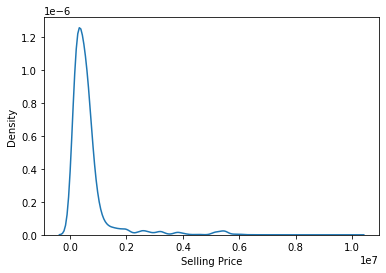

In [59]:
sns.distplot(df['selling_price'], hist=False)
plt.xlabel("Selling Price")
plt.ylabel("Density")
plt.show()

The selling price is distributed around 450000, but there are many data points with much higher values. Let's check the distribution of this and a few other variables 

In [60]:
#Checking the distribution of various variables in the data
df.describe([0.25, 0.5, 0.75, 0.9, 0.95])

,year,selling_price,km_driven,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
count,7907.000000,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,2013.982168,6.497417e+05,6.919256e+04,19.335956,1458.625016,91.580217,180.261194,5.416719
std,3.866650,8.135565e+05,5.678976e+04,4.044932,503.916303,35.750619,109.396519,0.959588
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.799999,14.900000,2.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050003,111.720000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,170.000000,5.000000
75%,2017.000000,6.900000e+05,9.575000e+04,22.320000,1582.000000,102.000000,209.000000,5.000000
90%,2018.000000,1.050000e+06,1.200000e+05,24.520000,2198.400000,140.000000,320.000000,7.000000
95%,2019.000000,2.000000e+06,1.500000e+05,25.800000,2499.000000,171.500000,360.000000,7.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,1862.000000,14.000000


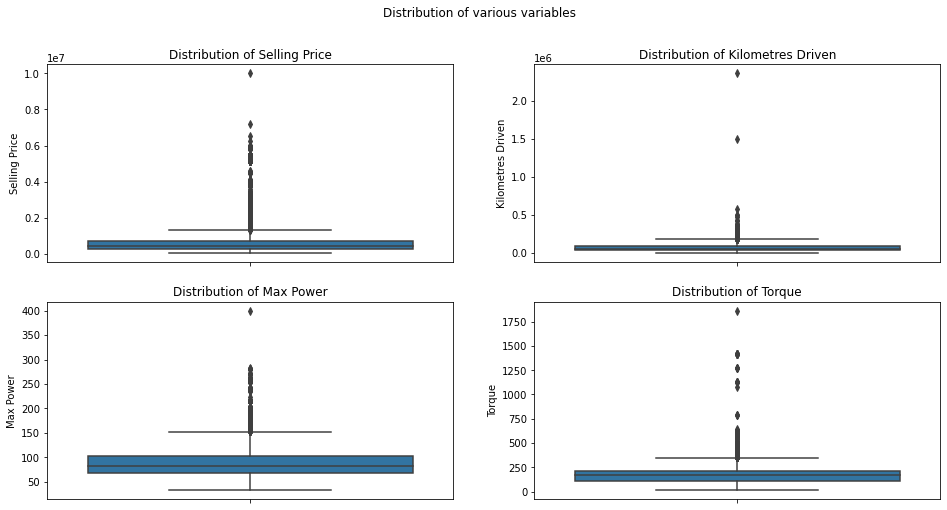

In [61]:
#Defining the plotting area
fig, axes = plt.subplots(2, 2, figsize=(16,8))

#Plotting the distribution of the selling price
sns.boxplot(y=df['selling_price'], ax=axes[0, 0])
axes[0, 0].set_ylabel("Selling Price")
axes[0, 0].set_title("Distribution of Selling Price")

#Plotting the distribution of kilometres driven
sns.boxplot(y=df['km_driven'], ax=axes[0, 1])
axes[0, 1].set_ylabel("Kilometres Driven")
axes[0, 1].set_title("Distribution of Kilometres Driven")

#Plotting the distribution of max power
sns.boxplot(y=df['max_power_in_bhp'], ax=axes[1, 0])
axes[1, 0].set_ylabel("Max Power")
axes[1, 0].set_title("Distribution of Max Power")

#Plotting the distribution of torque
sns.boxplot(y=df['torque'], ax=axes[1, 1])
axes[1, 1].set_ylabel("Torque")
axes[1, 1].set_title("Distribution of Torque")

fig.suptitle("Distribution of various variables")

plt.show()

Let's check the outliers in these variables.

### Selling Price--Outliers

In [62]:
#Viewing the data points where the selling price is in the top 0.1 percentile
df[df['selling_price']>=df['selling_price'].quantile(0.999)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
136,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987,254.789993,620.0,5
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969,400.000000,640.0,4
1071,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.399994,620.0,4
2938,BMW X7 xDrive 30d DPE,2020,7200000,5000,Diesel,Individual,Automatic,First Owner,13.38,2993,265.000000,620.0,7
4101,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.399994,620.0,4
4766,BMW 6 Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.399994,620.0,4
4950,Audi A6 35 TFSI Matrix,2019,6223000,7800,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798,187.740005,320.0,5
4952,Audi A6 35 TFSI Matrix,2019,6523000,23600,Petrol,Dealer,Automatic,Test Drive Car,15.26,1798,187.740005,320.0,5
5258,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987,254.789993,620.0,5
7713,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987,254.789993,620.0,5


Most of these vehicles are from BMW, Mercedes, or Audi, suggesting that they are correct entries. The car with the highest selling price is a Volvo XC90. Let's check if there are other cars from the Volvo XC series in the database.

In [63]:
#Checking for vehicles with 'XC' in their name
df[df['name'].str.contains('XC')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
145,Volvo XC40 D4 R-Design,2018,3400000,22000,Diesel,Dealer,Automatic,First Owner,18.0,1969,190.0,400.0,5
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969,400.0,640.0,4
374,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
413,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
650,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
1081,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
1100,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
1119,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
1138,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5
1713,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0,1969,190.0,400.0,5


The data point with the highest selling price appears to be a legitimate entry. It is a high-end vehicle that has a similar selling price to other cars in the top 0.1 percentile. It is 1.8 times more expensive than a Volvo XC60, a similar vehicle from the same brand.

### Kilometres Driven--Outliers

In [64]:
#Checking the entries where the kilometres driven are in the top 0.05 percentile
df[df['km_driven']>=df['km_driven'].quantile(0.9995)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
1810,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,15.10,2179,140.000000,330.0,7
3486,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.60,1197,81.830002,114.7,5
3508,Maruti Wagon R LXI Minor,2010,194000,577414,Petrol,Individual,Manual,Second Owner,18.90,1061,67.000000,84.0,5
3641,Maruti Wagon R VXI BS IV,2011,229999,500000,Petrol,Individual,Manual,Second Owner,18.90,998,67.099998,90.0,5
6673,Toyota Innova 2.5 EV Diesel PS 7 Seater BSIII,2011,350000,500000,Diesel,Individual,Manual,Second Owner,12.99,2494,100.570000,200.0,7


From these results, we see that two vehicles have a substantially higher value in the km_driven column than the others. Their selling price does not appear to have decreased significantly either. These two data points are likely to be incorrect entries. Therefore, let's drop them.

In [65]:
#Dropping the two entries with the highest kilometres driven
print("Number of rows before dropping data points: ", df.shape[0])
df = df[df['km_driven'] < 1000000]
print("Number of rows after dropping data points: ", df.shape[0])

Number of rows before dropping data points:  7907
Number of rows after dropping data points:  7905


### Torque--Outliers

In [66]:
#Viewing the rows where the torque values are in the top 0.5 percentile
df[df['torque']>=df['torque'].quantile(0.995)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
136,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987,254.789993,620.0,5
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969,400.000000,640.0,4
604,Tata Sumo CX 10 Str BSIV,2011,175000,20000,Diesel,Individual,Manual,First Owner,12.20,1948,68.000000,1127.0,10
951,Maruti Zen D,2003,85000,120000,Diesel,Individual,Manual,Third Owner,20.80,1527,58.000000,789.0,5
1071,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09,2993,261.399994,620.0,4
1211,Maruti SX4 Vxi BSIII,2007,160000,120000,Petrol,Individual,Manual,Second Owner,15.00,1586,104.680000,1421.0,5
2086,Tata Sumo EX 10/7 Str BSIII,2012,200000,67500,Diesel,Individual,Manual,First Owner,12.20,1948,68.000000,1127.0,10
2289,Maruti SX4 Zxi BSIII,2010,300000,22000,Petrol,Individual,Manual,First Owner,15.00,1586,104.680000,1421.0,5
2314,Maruti SX4 Zxi with Leather BSIII,2008,150000,89000,Petrol,Individual,Manual,Second Owner,15.60,1586,104.680000,1421.0,5
2421,Ford Ikon 1.6 Nxt,2009,180000,70000,Petrol,Individual,Manual,Second Owner,14.20,1597,92.000000,1274.0,5


Some of the cars in this list are powerful vehicles with high torque, power, and engine capacity. However, some entries, such as the Maruti Zen and Tata Sumo have disproportionately high torque when compared to the power and engine capacity. Let's filter out such entries.

In [67]:
#Checking for data points where the torque is more than four times the max power
df[df['torque']>=(df['max_power_in_bhp']*4)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
604,Tata Sumo CX 10 Str BSIV,2011,175000,20000,Diesel,Individual,Manual,First Owner,12.2,1948,68.00,1127.0,10
951,Maruti Zen D,2003,85000,120000,Diesel,Individual,Manual,Third Owner,20.8,1527,58.00,789.0,5
1211,Maruti SX4 Vxi BSIII,2007,160000,120000,Petrol,Individual,Manual,Second Owner,15.0,1586,104.68,1421.0,5
2086,Tata Sumo EX 10/7 Str BSIII,2012,200000,67500,Diesel,Individual,Manual,First Owner,12.2,1948,68.00,1127.0,10
2289,Maruti SX4 Zxi BSIII,2010,300000,22000,Petrol,Individual,Manual,First Owner,15.0,1586,104.68,1421.0,5
2314,Maruti SX4 Zxi with Leather BSIII,2008,150000,89000,Petrol,Individual,Manual,Second Owner,15.6,1586,104.68,1421.0,5
2421,Ford Ikon 1.6 Nxt,2009,180000,70000,Petrol,Individual,Manual,Second Owner,14.2,1597,92.00,1274.0,5
2880,Ford Ikon 1.6 EXi NXt,2003,150000,40000,Petrol,Individual,Manual,Third Owner,14.2,1597,92.00,1274.0,5
4149,Maruti SX4 Vxi BSIII,2009,150000,110000,Petrol,Individual,Manual,First Owner,15.0,1586,104.68,1421.0,5
4309,Maruti SX4 Vxi BSIII,2007,125000,120000,Petrol,Individual,Manual,Third Owner,15.0,1586,104.68,1421.0,5


A quick google search shows that the torque values in these entries are 10 times higher than the actual torque ratings for these vehicles. Let's rectify these entries.

In [68]:
#Dividing these disproportionate torque values by 10
df['torque'][df['torque']>=(df['max_power_in_bhp']*4)] = df['torque'][df['torque']>=(df['max_power_in_bhp']*4)].apply(lambda x: x/10)

#Checking the distribution of the variable
df['torque'].describe()

count    7905.000000
mean      176.678439
std        90.176486
min        14.900000
25%       111.720000
50%       170.000000
75%       205.000000
max       640.000000
Name: torque, dtype: float64

Next, let's check the mileage variable.

### Mileage--Outliers

In [69]:
#Viewing the data points where the mileage is below the bottom 0.25 percentile
df[df['mileage_in_kmpl'] < df['mileage_in_kmpl'].quantile(0.0025)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
644,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.000,1172,65.000000,96.04,5
785,Hyundai Santro Xing GL,2009,120000,90000,Petrol,Individual,Manual,Second Owner,0.000,1086,62.000000,96.10,5
1649,Hyundai Santro Xing GL,2008,105000,128000,Petrol,Individual,Manual,First Owner,0.000,1086,62.000000,96.10,5
1676,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.000,2987,165.000000,510.00,5
2137,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.000,2179,115.000000,400.00,5
2366,Hyundai Santro Xing (Non-AC),2010,110000,80000,Petrol,Individual,Manual,Second Owner,0.000,1086,62.099998,96.10,5
2725,Hyundai Santro Xing (Non-AC),2013,184000,15000,Petrol,Individual,Manual,First Owner,0.000,1086,62.099998,96.10,5
3466,Maruti Omni LPG CARGO BSIII W IMMOBILISER,2010,120000,170000,LPG,Individual,Manual,Second Owner,6.056,796,32.799999,57.00,5
4527,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.000,2987,165.000000,510.00,5
5276,Hyundai Santro Xing GL,2008,175000,40000,Petrol,Individual,Manual,First Owner,0.000,1086,62.000000,96.10,5


Since mileage cannot be zero, these values need to be replaced. Let's check if the mileage value is available for these car models or their variants.

#### Santro Xing

In [70]:
#Checking the mileage of Santro Xing GL
df[df['name'].str.contains('Xing')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
128,Hyundai Santro Xing GLS,2009,135000,80000,Petrol,Individual,Manual,Second Owner,17.920,1086,62.099998,96.10,5
241,Hyundai Santro Xing GLS,2011,165000,75000,Petrol,Individual,Manual,First Owner,17.920,1086,62.099998,96.10,5
687,Hyundai Santro Xing GLS,2014,238000,60000,Petrol,Individual,Manual,First Owner,17.920,1086,62.099998,96.10,5
689,Hyundai Santro Xing GLS,2013,200000,90000,Petrol,Individual,Manual,First Owner,17.920,1086,62.099998,96.10,5
691,Hyundai Santro Xing GL Plus,2009,114999,90000,Petrol,Individual,Manual,Fourth & Above Owner,17.920,1086,62.099998,96.10,5
785,Hyundai Santro Xing GL,2009,120000,90000,Petrol,Individual,Manual,Second Owner,0.000,1086,62.000000,96.10,5
831,Hyundai Santro Xing XS,2007,95000,100000,Petrol,Individual,Manual,Second Owner,17.800,1086,63.000000,96.04,5
1339,Hyundai Santro Xing GLS,2010,150000,60000,Petrol,Individual,Manual,Third Owner,17.920,1086,62.099998,96.10,5
1355,Hyundai Santro Xing GLS,2014,220000,40000,Petrol,Individual,Manual,First Owner,17.920,1086,62.099998,96.10,5
1604,Hyundai Santro Xing GLS,2010,160000,65000,Petrol,Individual,Manual,Second Owner,17.920,1086,62.099998,96.10,5


The Santro Xing's mileage is either 17.92 or 17.8 kmpl (when the fuel type is Petrol.

In [71]:
#Imputing this value in place of zero
df['mileage_in_kmpl'][(df['name'].str.contains('Xing')) & (df['mileage_in_kmpl'] == 0) & (df['fuel'] == 'Petrol')] = 17.92

#### Mercedes ML 350

In [72]:
#Checking the mileage of Mercedes ML 350
df[df['name'].str.contains('ML 350')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
1676,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.00,2987,165.000000,510.0,5
2705,Mercedes-Benz M-Class ML 350 CDI,2013,3600000,50000,Diesel,Individual,Automatic,First Owner,11.74,2987,254.800003,619.0,5
4527,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.00,2987,165.000000,510.0,5
7808,Mercedes-Benz M-Class ML 350 CDI,2014,2575000,70000,Diesel,Individual,Automatic,First Owner,11.74,2987,254.800003,619.0,5


In [73]:
#Imputing 11.74 in place of zero
df['mileage_in_kmpl'][(df['name'].str.contains('ML 350')) & (df['mileage_in_kmpl']==0)] = 11.74

#### Mercedes GLC

In [74]:
#Checking for Mercedes GLC vehicles
df[df['name'].str.contains('GLC')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
7337,Mercedes-Benz GLC 220d 4MATIC,2017,3300000,60000,Diesel,Dealer,Automatic,First Owner,0.0,1950,194.0,400.0,5


This is the only entry for a Mercedes GLC. Let's search for other Mercedes cars with similar features.

In [75]:
#Refining the search
df[(df['name'].str.contains('220')) & (df['name'].str.contains('GL')) & (df['transmission']=='Automatic')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
288,Mercedes-Benz GL-Class 220d 4MATIC Sport,2018,4600000,7976,Diesel,Individual,Automatic,First Owner,17.9,2143,170.0,400.0,5
7337,Mercedes-Benz GLC 220d 4MATIC,2017,3300000,60000,Diesel,Dealer,Automatic,First Owner,0.0,1950,194.0,400.0,5
7340,Mercedes-Benz GL-Class 220d 4MATIC Sport,2018,4600000,6000,Diesel,Dealer,Automatic,First Owner,17.9,2143,170.0,400.0,5


In [76]:
#Imputing 17.9
df['mileage_in_kmpl'][(df['name'].str.contains('GLC')) & (df['mileage_in_kmpl']==0)] = 17.9

#### Mahindra Bolero

In [77]:
#Checking the mileage of Mahindra Bolero
df[(df['name'].str.contains('Bolero')) & (df['engine_in_cc']==2523)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
286,Mahindra Bolero SLE,2009,400000,170000,Diesel,Individual,Manual,Second Owner,13.60,2523,63.000000,180.0,7
287,Mahindra Bolero DI DX 7 Seater,2007,210000,207890,Diesel,Individual,Manual,Second Owner,13.60,2523,63.000000,180.0,7
297,Mahindra Bolero 2011-2019 ZLX,2014,509999,120000,Diesel,Individual,Manual,First Owner,15.96,2523,62.099998,195.0,7
457,Mahindra Bolero 2011-2019 SLE,2015,375000,80000,Diesel,Individual,Manual,First Owner,15.96,2523,62.099998,195.0,7
515,Mahindra Bolero 2011-2019 DI 4WD NON AC,2012,320000,80000,Diesel,Individual,Manual,Second Owner,13.60,2523,63.000000,180.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7466,Mahindra Bolero SLX,2011,370000,110000,Diesel,Individual,Manual,Second Owner,13.60,2523,63.000000,180.0,7
7650,Mahindra Bolero 2011-2019 ZLX,2012,430000,50000,Diesel,Individual,Manual,First Owner,15.96,2523,62.099998,195.0,7
7660,Mahindra Bolero 2011-2019 SLX,2013,475000,76000,Diesel,Individual,Manual,First Owner,15.96,2523,62.099998,195.0,7
7698,Mahindra Bolero SLE BSIII,2011,400000,70000,Diesel,Individual,Manual,Second Owner,13.60,2523,63.000000,180.0,7


Let's impute the median of these values.

In [78]:
#Calculating the median mileage for Boleros
bolero_mileage = round(df['mileage_in_kmpl'][(df['name'].str.contains('Bolero')) & (df['mileage_in_kmpl']>0) & 
                                            (df['engine_in_cc']==2523)].median(), 2)
print("Median mileage for Boleros: ", bolero_mileage)

Median mileage for Boleros:  15.96


In [79]:
#Imputing the median in place of zeros
df['mileage_in_kmpl'][(df['name'].str.contains('Bolero')) & (df['mileage_in_kmpl']==0)] = bolero_mileage

#### Volkswagen Polo

In [80]:
#Checking the mileage of similar VW Polos
df[(df['name'].str.contains('Polo')) & (df['fuel']=='Petrol') & (df['transmission']=='Automatic') & (df['engine_in_cc']==1197)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
3359,Volkswagen Polo GT TSI,2014,550000,31000,Petrol,Dealer,Automatic,Second Owner,17.21,1197,103.599998,175.0,5
4768,Volkswagen Polo GT TSI,2016,675000,69000,Petrol,Dealer,Automatic,First Owner,17.20,1197,103.599998,175.0,5
5843,Volkswagen Polo GT TSI BSIV,2014,574000,28080,Petrol,Dealer,Automatic,First Owner,0.00,1197,103.250000,175.0,5
5846,Volkswagen Polo GT TSI BSIV,2014,575000,28100,Petrol,Dealer,Automatic,First Owner,0.00,1197,103.250000,175.0,5
6012,Volkswagen Polo GT TSI,2013,453000,54327,Petrol,Dealer,Automatic,Second Owner,17.20,1197,103.599998,175.0,5


In [81]:
#Imputing 17.2 in place of zeroes
df['mileage_in_kmpl'][(df['name'].str.contains('Polo')) & (df['mileage_in_kmpl']==0)] = 17.2

In [82]:
#Checking for zero mileage vehicles again
df[df['mileage_in_kmpl']==0]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
644,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.0,1172,65.0,96.04,5
2137,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0,2179,115.0,400.00,5


#### Indica Vista

In [83]:
#Checking the mileage of Indica Vistas with similar features
df[(df['name'].str.contains('Indica Vista')) & (df['fuel']=='Petrol') & (df['engine_in_cc']==1172)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
109,Tata Indica Vista Aura 1.2 Safire (ABS) BS IV,2010,300000,48000,Petrol,Individual,Manual,First Owner,15.8,1172,65.000000,96.00,5
644,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.0,1172,65.000000,96.04,5
4716,Tata Indica Vista Safire GLX,2014,210000,35000,Petrol,Individual,Manual,Second Owner,16.7,1172,64.099998,96.00,5
4856,Tata Indica Vista Aura 1.2 Safire (ABS) 90hp B...,2010,150000,29000,Petrol,Individual,Manual,First Owner,16.5,1172,65.000000,96.00,5
5687,Tata Indica Vista Aura 1.2 Safire (ABS) 90hp B...,2011,150000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172,65.000000,96.00,5
8032,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172,65.000000,96.00,5


In [84]:
#Imputing 16.5
df['mileage_in_kmpl'][(df['name'].str.contains('Vista')) & (df['mileage_in_kmpl']==0)] = 16.5

#### Land Rover

In [85]:
#Checking the mileage of Land Rovers
df[df['name'].str.contains('Land Rover')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
135,Land Rover Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83,1999,148.309998,382.0,7
2137,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.00,2179,115.000000,400.0,5
3240,Land Rover Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83,1999,148.309998,382.0,7
5257,Land Rover Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83,1999,148.309998,382.0,7
6724,Land Rover Range Rover Evoque 2.2L Pure,2013,2000000,77500,Diesel,Individual,Automatic,Third Owner,12.70,2179,187.699997,420.0,5
7711,Land Rover Discovery Sport TD4 SE,2019,4500000,21000,Diesel,Dealer,Automatic,First Owner,12.83,1999,148.309998,382.0,7


Here, let's impute 12.7 as the mileage, as the only other Land Rover with a 2179CC engine has that mileage.

In [86]:
#Imputing 12.7 inplace of zero
df['mileage_in_kmpl'][(df['name'].str.contains("Land Rover")) & (df['mileage_in_kmpl']==0)] = 12.7

In [87]:
#Checking the distribution of this variables again
df['torque'].describe()

count    7905.000000
mean      176.678439
std        90.176486
min        14.900000
25%       111.720000
50%       170.000000
75%       205.000000
max       640.000000
Name: torque, dtype: float64

# Data Preparation

In [88]:
df.columns.to_list()

['name',
 'year',
 'selling_price',
 'km_driven',
 'fuel',
 'seller_type',
 'transmission',
 'owner',
 'mileage_in_kmpl',
 'engine_in_cc',
 'max_power_in_bhp',
 'torque',
 'seats']

In [89]:
#Converting the 'year' column to 'years_owned' by deducting from the current year
df['year'] = 2022 - df['year']

In [90]:
#Renaming the column to 'years_owned'
df.rename(columns={'year': 'years_owned'}, inplace=True)
df.head(2)

,name,years_owned,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats
0,Maruti Swift Dzire VDI,8,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.000000,190.0,5
1,Skoda Rapid 1.5 TDI Ambition,8,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.519997,250.0,5


### Encoding Ordinal Variables

The only ordinal variable is 'owner'.

In [91]:
#Checking the value counts before encoding
df['owner'].value_counts()

First Owner             5214
Second Owner            2016
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: owner, dtype: int64

In [92]:
#Mapping the type of owner to different numerical values
df['owner'] = df['owner'].map({'First Owner': 1, 'Second Owner':2, 'Third Owner':3, 'Fourth & Above Owner':4, 'Test Drive Car':0})

In [93]:
#Checking the value counts after encoding
df['owner'].value_counts()

1    5214
2    2016
3     510
4     160
0       5
Name: owner, dtype: int64

### Encoding Nominal Variables

The nominal variables in this dataset are 'fuel', 'seller_type', and 'transmission'. Let's view the number of levels in each of them.

In [94]:
df['fuel'].value_counts()

Diesel    4298
Petrol    3519
CNG         53
LPG         35
Name: fuel, dtype: int64

In [95]:
df['seller_type'].value_counts()

Individual          6562
Dealer              1107
Trustmark Dealer     236
Name: seller_type, dtype: int64

In [96]:
df['transmission'].value_counts()

Manual       6864
Automatic    1041
Name: transmission, dtype: int64

The 'transmission' column can be mapped to 0s and 1s, since it has only two levels.

In [97]:
#Mapping 'Manual' to 1 and 'Automatic' to 0
df['transmission'] = df['transmission'].map({'Manual':1, 'Automatic':0})

#Checking the value counts after mapping
df['transmission'].value_counts()

1    6864
0    1041
Name: transmission, dtype: int64

One hot encoding can be applied to the 'fuel' and 'seller_type' columns since they have more than two levels.

In [98]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [99]:
#Using OneHotEncoder for the two columns that have more than two levels
onehotlabels = enc.fit_transform(df[['fuel', 'seller_type']])
#onehotlabels is a sparse matrix with a very large number of rows
onehotlabels.shape

(7905, 7)

In [100]:
#Using the original column names to make the encoded columns easier to read
col_names = enc.get_feature_names(['fuel', 'seller_type'])
col_names.tolist()

['fuel_CNG',
 'fuel_Diesel',
 'fuel_LPG',
 'fuel_Petrol',
 'seller_type_Dealer',
 'seller_type_Individual',
 'seller_type_Trustmark Dealer']

In [101]:
#Converting the encoded columns (that are in a sparse array) into a dataframe
#Using the col_names variable to assign names to the dataframe's columns
ohe_df = pd.DataFrame(onehotlabels.toarray().astype(int), columns=col_names)
ohe_df.head()

,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,0,1,0,0,0,1,0
1,0,1,0,0,0,1,0
2,0,0,0,1,0,1,0
3,0,1,0,0,0,1,0
4,0,0,0,1,0,1,0


We can drop some of these columns as we only need n-1 columns in each category.

In [102]:
#Dropping LPG and Trustmark Dealer columns as they have the least number of occurrences
ohe_df.drop(['fuel_LPG', 'seller_type_Trustmark Dealer'], axis=1, inplace=True)

In [103]:
ohe_df.head()

,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
0,0,1,0,0,1
1,0,1,0,0,1
2,0,0,1,0,1
3,0,1,0,0,1
4,0,0,1,0,1


In [104]:
#Checking the dimensions of the encoded data
ohe_df.shape

(7905, 5)

In [105]:
#Checking the dimensions of the original data
df.shape

(7905, 13)

#### Merging the encoded columns with the original dataframe

In [106]:
#Resetting the indices of both dataframes before merging
#This is to avoid having 
df.reset_index(inplace=True)
ohe_df.reset_index(inplace=True)

In [107]:
carprice_df = pd.concat([df, ohe_df], axis=1)
carprice_df.head(3)

,index,name,years_owned,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats,index,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
0,0,Maruti Swift Dzire VDI,8,450000,145500,Diesel,Individual,1,1,23.40,1248,74.000000,190.00,5,0,0,1,0,0,1
1,1,Skoda Rapid 1.5 TDI Ambition,8,370000,120000,Diesel,Individual,1,2,21.14,1498,103.519997,250.00,5,1,0,1,0,0,1
2,2,Honda City 2017-2020 EXi,16,158000,140000,Petrol,Individual,1,3,17.70,1497,78.000000,124.46,5,2,0,0,1,0,1


Let's drop the columns that have now been encoded: fuel and seller_type.

In [108]:
#Checking the dimensions of the dataframe before dropping columns
carprice_df.shape

(7905, 20)

In [109]:
#Dropping the columns
carprice_df.drop(['fuel', 'seller_type', 'index'], axis=1, inplace=True)

#Checking the dimensions of the dataframe after dropping columns
carprice_df.shape

(7905, 16)

## Train-Test Split

In [110]:
#Splitting the data 70-30
df_train, df_test = train_test_split(carprice_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [111]:
#Checking the dimensions of the two dataframes
print("Train data: ", df_train.shape)
print("Test data: ", df_test.shape)

Train data:  (5533, 16)
Test data:  (2372, 16)


### Rescaling Features

In [112]:
df_train.head(3)

,name,years_owned,selling_price,km_driven,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
1804,Jaguar XF 2.0 Diesel Portfolio,5,3200000,45000,0,1,19.33,1999,177.000000,430.0,5,0,1,0,1,0
6413,Mahindra XUV500 W8 4WD,10,900000,100000,1,1,15.10,2179,140.000000,330.0,7,0,1,0,0,1
1005,Maruti Swift Dzire VDI,3,757000,25000,1,1,28.40,1248,74.019997,190.0,5,0,1,0,0,1


In [113]:
#Creating a minmaxscaler object
scaler = MinMaxScaler()

In [114]:
#Making a list of numerical variables that are to be scaled
numerical_variables = ['years_owned', 'selling_price', 'km_driven', 'mileage_in_kmpl', 'engine_in_cc', 'max_power_in_bhp', 
                       'torque', 'seats']

In [115]:
#Rescaling the numerical variables in the dataframe
df_train[numerical_variables] = scaler.fit_transform(df_train[numerical_variables])
df_train.head(3)

,name,years_owned,selling_price,km_driven,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
1804,Jaguar XF 2.0 Diesel Portfolio,0.12,0.317954,0.077932,0,1,0.369297,0.461409,0.392702,0.664054,0.250000,0,1,0,1,0
6413,Mahindra XUV500 W8 4WD,0.32,0.087262,0.173185,1,1,0.251614,0.521812,0.291939,0.504079,0.416667,0,1,0,0,1
1005,Maruti Swift Dzire VDI,0.04,0.072919,0.043295,1,1,0.621634,0.209396,0.112255,0.280115,0.250000,0,1,0,0,1


### Dividing the training set into X and Y for model building

In [116]:
#Using the pop funtion to get the predictor variables
y_train = df_train.pop('selling_price')
y_train.shape

(5533,)

In [117]:
#Viewing the columns in the dataframe
df_train.columns.tolist()

['name',
 'years_owned',
 'km_driven',
 'transmission',
 'owner',
 'mileage_in_kmpl',
 'engine_in_cc',
 'max_power_in_bhp',
 'torque',
 'seats',
 'fuel_CNG',
 'fuel_Diesel',
 'fuel_Petrol',
 'seller_type_Dealer',
 'seller_type_Individual']

Let's use only the columns that were retained after checking their p-values and VIF (in the other IPython notebook).

In [118]:
#Removing 'name' from the list of columns as it cannot be used for modeling
col_names = df_train.columns.tolist()
col_names.remove('name')
col_names

['years_owned',
 'km_driven',
 'transmission',
 'owner',
 'mileage_in_kmpl',
 'engine_in_cc',
 'max_power_in_bhp',
 'torque',
 'seats',
 'fuel_CNG',
 'fuel_Diesel',
 'fuel_Petrol',
 'seller_type_Dealer',
 'seller_type_Individual']

In [119]:
X_train = df_train[col_names]
X_train.head(3)

,years_owned,km_driven,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
1804,0.12,0.077932,0,1,0.369297,0.461409,0.392702,0.664054,0.250000,0,1,0,1,0
6413,0.32,0.173185,1,1,0.251614,0.521812,0.291939,0.504079,0.416667,0,1,0,0,1
1005,0.04,0.043295,1,1,0.621634,0.209396,0.112255,0.280115,0.250000,0,1,0,0,1


# Model Building

## 1. Linear Regression

In [120]:
#Creating an Linear Regression object
reg = LinearRegression()

In [121]:
#Fitting the model to the train set
reg.fit(X_train, y_train)

LinearRegression()

In [122]:
#Getting the r-squared value for the train set
reg.score(X_train, y_train)

0.6823956737417984

### Rescaling the test set

In [123]:
#All the numerical variables that were used to fit the scaler need to be rescaled in the training set
df_test[numerical_variables] = scaler.transform(df_test[numerical_variables])

### Dividing the test set into X and y

In [124]:
y_test = df_test.pop('selling_price')
X_test = df_test.copy()

### Preparing the test set for modelling

In [125]:
#Dropping the columns in that test set that are not present in the train set
X_test = X_test[X_train.columns.tolist()]

In [126]:
X_test.head()

,years_owned,km_driven,transmission,owner,mileage_in_kmpl,engine_in_cc,max_power_in_bhp,torque,seats,fuel_CNG,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual
5244,0.32,0.166257,0,2,0.377365,0.461074,0.428105,0.616061,0.250000,0,1,0,1,0
7861,0.48,0.173185,1,2,0.151458,0.458725,0.313453,0.488082,0.416667,0,1,0,0,1
5968,0.16,0.069273,1,1,0.357334,0.192282,0.133987,0.158535,0.250000,0,0,1,0,1
7032,0.20,0.242459,1,1,0.251614,0.521812,0.291939,0.504079,0.416667,0,1,0,0,1
4791,0.32,0.121229,1,3,0.419096,0.209396,0.152505,0.296113,0.250000,0,1,0,0,1


### Making Predictions on the test set

In [127]:
#Using the fitted model to predict the target variable of the test set
y_test_pred = reg.predict(X_test)

In [128]:
#Calculating R-squared and MAPE for the predicted values
r2_LR = r2_score(y_test, y_test_pred)
MAPE_LR = np.mean(np.abs((y_test - y_test_pred)/y_test))*100

In [129]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_LR)
print("MAPE: ", MAPE_LR)

R-Squared:  0.684087911455916
MAPE:  132.72395852981336


The R-squared value of the predictions for the test set (0.6841) is slightly higher than the R-squared value of the train set, showing that the model is generalizing well. However, MAPE of 133% is very high. The R-squared values of the model on the train and test set show that the model is underfitting.

## 2. Decision Tree Regressor

In [130]:
#Creating an instance of the dtree regressor object
dtree_regressor = DecisionTreeRegressor(random_state=100) 

In [131]:
#Fitting the regressor on the train data set
dtree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [132]:
#Checking the model's R-squared value on the train set
dtree_regressor.score(X_train, y_train)

0.9996751878178853

In [133]:
#Using the fitted model to predict the target variable of the test set
y_test_pred_dtree = dtree_regressor.predict(X_test)

In [134]:
#Calculating R-squared and MAPE for the predicted values
r2_dtree = r2_score(y_test, y_test_pred_dtree)
MAPE_dtree = np.mean(np.abs((y_test - y_test_pred_dtree)/y_test))*100

In [135]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_dtree)
print("MAPE: ", MAPE_dtree)

R-Squared:  0.9645170768294068
MAPE:  21.161515587340173


Let's visualize the decision tree.

In [136]:
#This code has been commented out as it takes a long time to execute
# plt.figure(figsize=(16,32))
# plot_tree(dtree_regressor)
# plt.show()

Let's get a sense of the size of the decision tree regressor.

In [137]:
print("Tree depth: ", dtree_regressor.get_depth())
print("Number of leaves in the tree: ", dtree_regressor.get_n_leaves())

Tree depth:  32
Number of leaves in the tree:  4384


From the tree depth and number of leaves, it appears that the decision tree is very large and elaborate. The R-squared score of 0.9997 on the train set supports this.

Let's also check which features are the most important predictors.

In [138]:
#Getting the importance of features from the decision tree regressor
feature_importance = list(dtree_regressor.feature_importances_)

#Getting the names of the columns in the train set
column_names = X_train.columns

In [139]:
#Creating a dataframe that contains column names and the importance of the column
feature_importance_df = pd.DataFrame({'Columns': column_names, 'Importance of Column': feature_importance})

#Sorting the dataframe by the importance column
feature_importance_df.sort_values('Importance of Column', ascending=False)

,Columns,Importance of Column
6,max_power_in_bhp,0.746669
0,years_owned,0.173985
7,torque,0.038702
4,mileage_in_kmpl,0.013757
1,km_driven,0.010096
13,seller_type_Individual,0.009049
5,engine_in_cc,0.003543
2,transmission,0.001628
3,owner,0.001129
8,seats,0.000835


This table shows that the max power column is the most important feature. This is followed by the years_owned feature.

## 3. KNN Regressor

In [140]:
#Instantiating the KNN regressor model
knn_regressor = KNeighborsRegressor()     #The default number of neighbors is 5

In [141]:
#Fitting the KNN regressor on the train data set
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [142]:
#Getting the R-squared score for the train set
knn_regressor.score(X_train, y_train)

0.9545333287061267

In [143]:
#Using the fitted model to predict the target variable of the test set
y_test_pred_knn = knn_regressor.predict(X_test)

In [144]:
#Calculating R-squared and MAPE for the predicted values
r2_knn = r2_score(y_test, y_test_pred_knn)
MAPE_knn = np.mean(np.abs((y_test - y_test_pred_knn)/y_test))*100

In [145]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_knn)
print("MAPE: ", MAPE_knn)

R-Squared:  0.9398998145054365
MAPE:  25.07392518213431


The R-squared value is lower than what was obtained from the decision tree regressor, but the MAPE is slightly higher.

## 4. Random Forest Regressor

In [146]:
#Instantiating the RF regressor model
rf_regressor = RandomForestRegressor()

#Fitting the RF regressor on the train data set
rf_regressor.fit(X_train, y_train)

RandomForestRegressor()

In [147]:
#Getting the R-squared score for the train set
rf_regressor.score(X_train, y_train)

0.9953230661199085

In [148]:
#Using the fitted model to predict the target variable of the test set
y_test_pred_rf = rf_regressor.predict(X_test)

#Calculating R-squared and MAPE for the predicted values
r2_rf = r2_score(y_test, y_test_pred_rf)
MAPE_rf = np.mean(np.abs((y_test - y_test_pred_rf)/y_test))*100

In [149]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_rf)
print("MAPE: ", MAPE_rf)

R-Squared:  0.9695486536920399
MAPE:  18.285377480524346


The Random Forest regressor performs well on the test set. The MAPE is also very low.

## 5. XGBoost Regressor

In [150]:
#Instantiating the XGB regressor model
xgb_regressor = XGBRegressor()

#Fitting the XGB regressor on the train data set
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
#Getting the R-squared score for the train set
xgb_regressor.score(X_train, y_train)

0.9958740380400536

In [154]:
#Using the fitted model to predict the target variable of the test set
y_test_pred_xgb = xgb_regressor.predict(X_test)

#Calculating R-squared and MAPE for the predicted values
r2_xgb = r2_score(y_test, y_test_pred_xgb)
MAPE_xgb = np.mean(np.abs((y_test - y_test_pred_xgb)/y_test))*100

In [155]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_xgb)
print("MAPE: ", MAPE_xgb)

R-Squared:  0.9755621311286271
MAPE:  17.941840402402885


The XGB regressor performs marginally better than the RF regressor. Both its R-squared and MAPE scores are slightly better.

Let's look at the scores of the models trained so far.

|| Model | R-Squared | MAPE |
| --- | --- | --- | --- |
| 1. | Linear Regression | 0.6841 | 132.7239 |
| 2. | Decision Tree | 0.9645 | 21.1615 |
| 3. | KNN | 0.9399 | 25.0739 |
| 4. | Random Forest | 0.9706 | 18.3369 |
| 5. | XGBoost | 0.9756 | 17.9418 |

Since the XGBoost model has the best performance, let's tune the hyperparameters of this model.

### Hyperparameter Tuning for XGB Regressor

In [156]:
#Defining the hyperparameter space
param_grid = {"n_estimators": [100, 120, 130, 140, 150],
              "max_depth": range(1,15),
              "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
              "learning_rate": [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
}

In [157]:
#Creating a grid search object
xgb_gridsearch = GridSearchCV(estimator = XGBRegressor(booster="gblinear", objective="reg:squarederror",  random_state=100), 
                              param_grid=param_grid, cv=4, verbose=1, n_jobs=-1)

#Passing the train set to grid search
xgb_gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 2450 candidates, totalling 9800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  2.4min


[14:32:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytree, max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 9800 out of 9800 | elapsed:  2.4min finished


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster='gblinear',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n...
                                    num_parallel_tree=None, random_state=100,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramet

In [158]:
#Getting the best parameters from the grid search
xgb_gridsearch.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 150}

In [159]:
#Using these parameters to fit an XGB regressor model
xgb_regressor_tuned = XGBRegressor(n_estimators=150, max_depth=7, learning_rate=0.1, colsample_bytree=0.9, n_jobs=-1)

#Fitting the XGB regressor on the train data set
xgb_regressor_tuned.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [160]:
#Getting the R-squared score for the train set
xgb_regressor_tuned.score(X_train, y_train)

0.9945529520019778

In [161]:
#Using the fitted model to predict the target variable of the test set
y_test_pred_xgb_tuned = xgb_regressor_tuned.predict(X_test)

#Calculating R-squared and MAPE for the predicted values
r2_xgb_tuned = r2_score(y_test, y_test_pred_xgb_tuned)
MAPE_xgb_tuned = np.mean(np.abs((y_test - y_test_pred_xgb_tuned)/y_test))*100

In [162]:
#Calculating R-squared and MAPE for the predicted values
print("R-Squared: ", r2_xgb_tuned)
print("MAPE: ", MAPE_xgb_tuned)

R-Squared:  0.9749882153566809
MAPE:  17.669806597158697
